In [1]:
import numpy as np
import pandas as pd

import time

import datetime
import matplotlib.pyplot as plt

import yfinance as yf
import nasdaqdatalink


import scipy.stats as scs
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
start1 = datetime.date(2011, 12, 25)
end1 = datetime.date(2022, 12, 31)
ticker1 = "NFLX"

In [3]:
df = yf.download(ticker1, start=start1, end=end1)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker1} data")

[*********************100%***********************]  1 of 1 completed
Downloaded 2772 rows and 6 columns of NFLX data


In [4]:
df1 = df.copy()

In [5]:
df1 = df1.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 
                             'Close':'last', 'Adj Close':'last'})

In [6]:
df1.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df1.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)

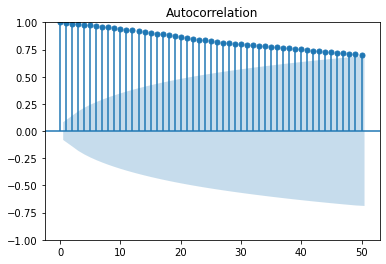

In [7]:
sm.graphics.tsa.plot_acf(df1['adj_close'], lags=50, alpha=0.05);

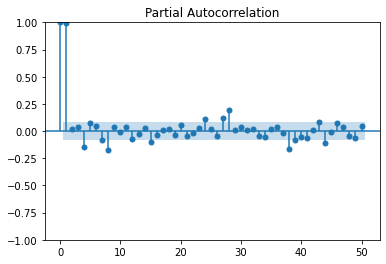

In [8]:
sm.graphics.tsa.plot_pacf(df1['adj_close'], lags=50, alpha=0.05);

In [9]:
train_end = datetime.date(2021, 7, 2)
test_end = end1

df1_train = df1[:train_end]
df1_test = df1[train_end + pd.Timedelta(days=1): test_end]

In [10]:
model1a = ARIMA(df1_train['adj_close'], order=(1, 0,0))

In [11]:
starting = time.time()
model1a_fit = model1a.fit()
ending = time.time()
print(f"Time taken to fit the model:{round(ending-starting, 2)} seconds")

Time taken to fit the model:0.43 seconds


In [12]:
print(model1a_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              adj_close   No. Observations:                  496
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1981.448
Date:                Sat, 25 Feb 2023   AIC                           3968.895
Time:                        15:28:07   BIC                           3981.515
Sample:                    01-01-2012   HQIC                          3973.849
                         - 06-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        190.8693    321.677      0.593      0.553    -439.606     821.345
ar.L1          0.9984      0.004    281.294      0.000       0.991       1.005
sigma2       170.7700      5.432     31.438      0.0

In [13]:
predict_start = df1_test.index[0]
predict_end = df1_test.index[-1]

In [14]:
# Predict the output in the test set
starting = time.time()
predicted_values = model1a_fit.predict(start= predict_start, end = predict_end)
residual_values = df1_test['adj_close'] - predicted_values
ending = time.time()

print(f"Time taken to forecast out-of-sample: {round(ending-starting, 2)} seconds")

Time taken to forecast out-of-sample: 0.03 seconds


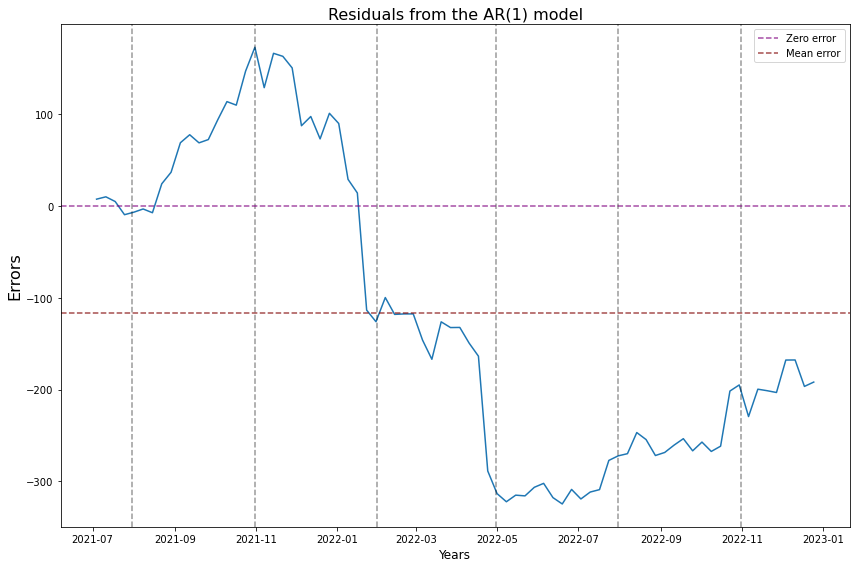

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(residual_values)
plt.title(f"Residuals from the AR(1) model", fontsize=16)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Errors", fontsize=16)
plt.tight_layout()

for every3months in pd.date_range(start=predict_start, end = predict_end, freq='3M'):
    plt.axvline(every3months, color='black', linestyle='--', alpha=0.4)


plt.axhline(0, label='Zero error', color = 'purple', linestyle='--', alpha=0.7)
plt.axhline(residual_values.mean(), label='Mean error', color='maroon', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

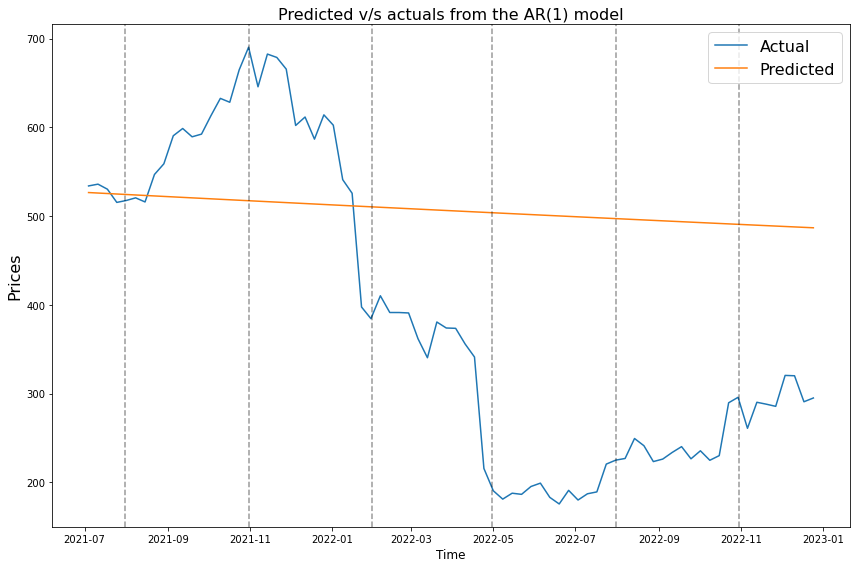

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(df1_test['adj_close'])
plt.plot(predicted_values)
plt.title(f"Predicted v/s actuals from the AR(1) model", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Prices", fontsize=16)

for every3months in pd.date_range(start=predict_start, end = predict_end, freq='3M'):
    plt.axvline(every3months, color='black', linestyle='--', alpha=0.4)
    
plt.legend(('Actual', 'Predicted'), fontsize=16 )
plt.tight_layout()

In [17]:
print("Mean absolute percent error:", round(np.mean(abs(residual_values/df1_test['adj_close'])), 3))
print("Root mean squared error:", round(np.sqrt(np.mean(residual_values**2)), 3))

Mean absolute percent error: 0.655
Root mean squared error: 197.063


In [18]:
model1b = ARIMA(df1_train['adj_close'], order=(1, 0,0))

starting = time.time()
model1b_fit = model1b.fit()
ending = time.time()
print(f"Time taken to fit the model: {round(ending-starting, 2)} seconds")

Time taken to fit the model: 0.35 seconds


In [19]:

def predict_price_AR(train_data):
    model = ARIMA(train_data, order=(1, 0,0))

    model_fit = model.fit()

    forecast_results = model_fit.forecast()

    return forecast_results[0]

In [20]:
rolling_window = df1_train.shape[0]

In [21]:
starting = time.time()

df1['predicted_price'] = df1['adj_close'].rolling(rolling_window).apply(predict_price_AR)
df1['predicted_price'] = df1['predicted_price'].shift(1)
df1['error'] = df1['adj_close'] - df1['predicted_price']
ending = time.time()
print(f"Time taken for the rolling forecasts: {round(ending-starting, 2)} seconds")

Time taken for the rolling forecasts: 20.0 seconds


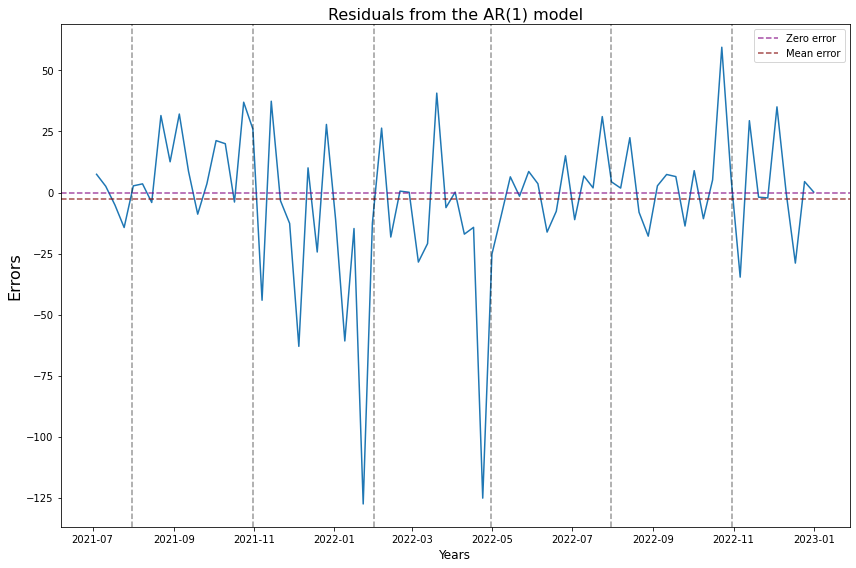

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(df1['error'])
plt.title(f"Residuals from the AR(1) model", fontsize=16)
plt.xlabel("Years", fontsize=12)
plt.ylabel("Errors", fontsize=16)
plt.tight_layout()

for every3months in pd.date_range(start=predict_start, end = predict_end, freq='3M'):
    plt.axvline(every3months, color='black', linestyle='--', alpha=0.4)


plt.axhline(0, label='Zero error', color = 'purple', linestyle='--', alpha=0.7)
plt.axhline(df1['error'].mean(), label='Mean error', color='maroon', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

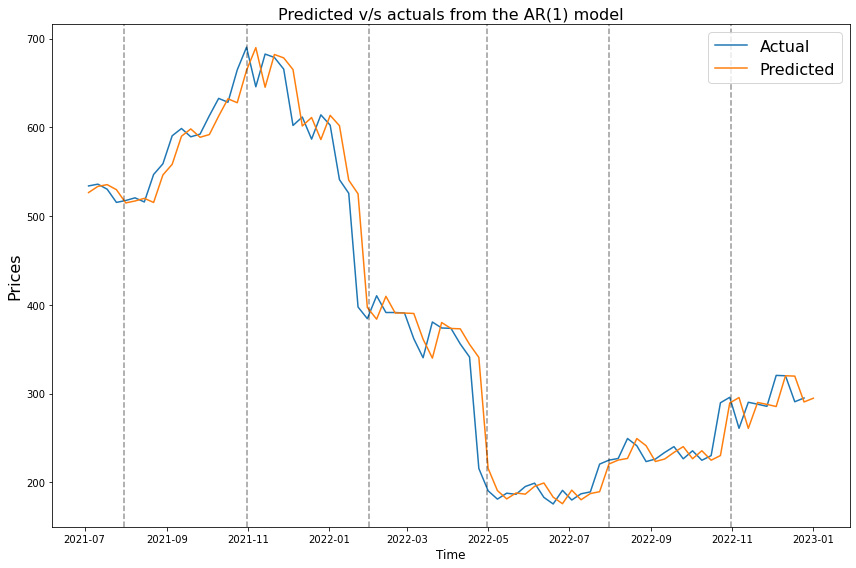

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(df1_test['adj_close'])
plt.plot(df1['predicted_price'])
plt.title(f"Predicted v/s actuals from the AR(1) model", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Prices", fontsize=16)

for every3months in pd.date_range(start=predict_start, end = predict_end, freq='3M'):
    plt.axvline(every3months, color='black', linestyle='--', alpha=0.4)
    
plt.legend(('Actual', 'Predicted'), fontsize=16 )
plt.tight_layout()

In [24]:
print("Mean absolute percent error:", round(np.mean(abs(df1['error']/df1.loc[predict_start:, 'adj_close'])), 3))
print("Root mean squared error:", round(np.sqrt(np.mean(df1['error']**2)), 3))

Mean absolute percent error: 0.054
Root mean squared error: 29.096


In [25]:
import matplotlib.dates as mdates

The Mean Absolute Error is 18.36
The Mean Squared Error is 846.60
The Root Mean Squared Error is 29.10
The Mean Absolute Percentage Error is 5.38


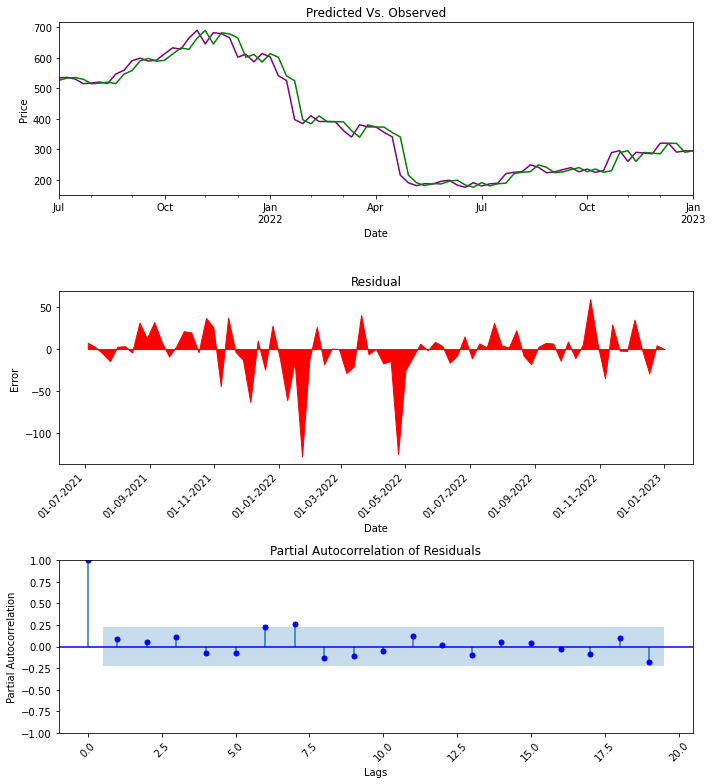

In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

def model_performance(observed, predicted):

    
    """This function will print the Mean Absolute Error, Mean Squared Error,
    Root Mean Squared Error and Mean Absolute Percentage Error.
    This function will also display the residula plot and the ACF.
    """

    # Mean Absolute Error
    mae = mean_absolute_error(observed, predicted)
    print('The Mean Absolute Error is %.2f' % mae)

    # Mean Squared Error
    mse = mean_squared_error(observed, predicted)
    print('The Mean Squared Error is %.2f' % mse)

    # Root Mean Squared Error
    rmse = sqrt(mean_squared_error(observed, predicted))
    print('The Root Mean Squared Error is %.2f' % rmse)

    # Mean Absolute Percentage Error
    mape = 100 * ((observed-predicted)/observed).abs().mean()
    print('The Mean Absolute Percentage Error is %.2f' % mape)

    # Residuals
    residuals = observed - predicted
    labels = observed.index
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 11))
    
    # Plot residual
    observed.plot(ax=ax1, color='purple')
    predicted.plot(ax=ax1, color='green')
    ax1.set_ylabel('Price')
    ax1.set_title('Predicted Vs. Observed')
    
    # Plot residual
    ax2.fill_between(residuals.index, residuals.values, color='red')
    ax2.set_ylabel('Error')
    ax2.set_xlabel('Date')
    ax2.set_title('Residual')
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))
    _=plt.xticks(rotation=45)
    
    # Autocorrelation plot of residuals
    sm.graphics.tsa.plot_pacf(residuals, ax=ax3, color='blue')
    ax3.set_xlabel('Lags')
    ax3.set_ylabel('Partial Autocorrelation')
    ax3.set_title('Partial Autocorrelation of Residuals')

    plt.tight_layout()
    plt.show()

model_performance(df1['adj_close'].iloc[rolling_window:],
                  df1['predicted_price'].iloc[rolling_window:])